# Create a truncated distribution

In this basic example we are going to truncate a distribution.

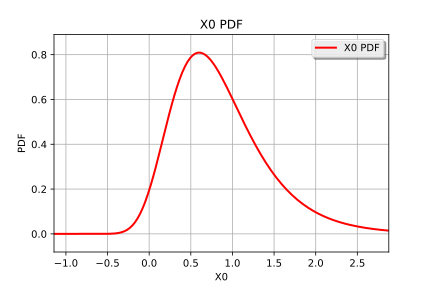

In [29]:
from __future__ import print_function
import openturns as ot

# the original distribution
distribution = ot.Gumbel(2.2, 0.6)
distribution.drawPDF()

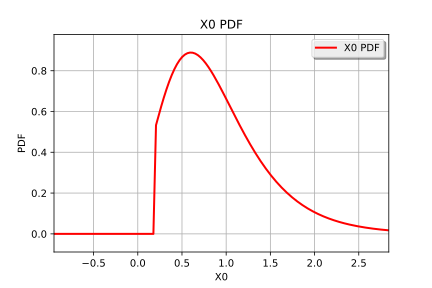

In [30]:
# truncate on the left
truncated = ot.TruncatedDistribution(distribution, 0.2, ot.TruncatedDistribution.LOWER)
truncated.drawPDF()

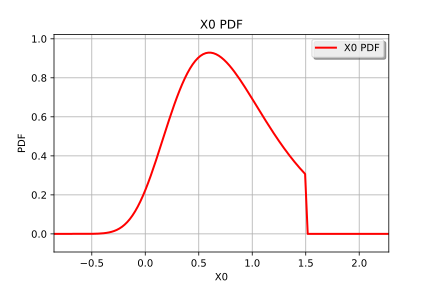

In [31]:
# truncate on the right
truncated = ot.TruncatedDistribution(distribution, 1.5, ot.TruncatedDistribution.UPPER)
truncated.drawPDF()

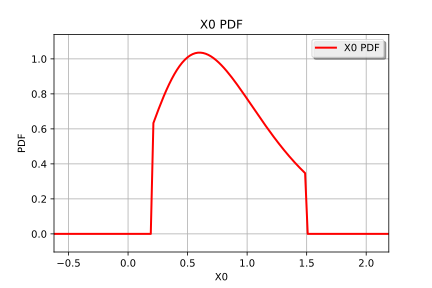

In [32]:
# truncated on both bounds
truncated = ot.TruncatedDistribution(distribution, 0.2, 1.5)
truncated.drawPDF()

In [33]:
# Custom class to truncate a multivariate distribution
class TruncatedNDDistribution(ot.PythonDistribution):
    def __init__(self, distribution, bounds):
        super(TruncatedNDDistribution, self).__init__(distribution.getDimension())
        if distribution.getDimension() != bounds.getDimension():
            raise ValueError('Distribution and bounds have incompatible dimension')
        bounds = bounds.intersect(distribution.getRange())
        self.distribution_ = distribution
        self.bounds_ = bounds
        self.lowerBound_ = bounds.getLowerBound()
        self.upperBound_ = bounds.getUpperBound()
        self.normalization_ = distribution.computeProbability(bounds)
        if self.normalization_ == 0.0:
            raise ValueError('The truncation bounds have a zero probability')
        
    def getRange(self):
        return self.bounds_
    
    def computePDF(self, X):
        if not self.bounds_.numericallyContains(X):
            return False
        return self.distribution_.computePDF(X) / self.normalization_

    def computeCDF(self, X):
        interval = self.bounds_.intersect(ot.Interval([-ot.SpecFunc.MaxScalar]*self.distribution_.getDimension(), X))
        return self.distribution_.computeProbability(interval) / self.normalization_

    def getRealization(self):
        stop = False
        while not stop:
            X = self.distribution_.getRealization()
            stop = self.bounds_.contains(X)
        return X

In [34]:
# Define a multivariate distribution
dimension = 2
size = 70
sample = ot.Normal(dimension).getSample(size)
ks = ot.KernelSmoothing().build(sample)

In [35]:
# Truncate it between (-2;2)^n
bounds = ot.Interval([-2.0] * dimension, [2.0] * dimension)
truncatedKS = ot.Distribution(TruncatedNDDistribution(ks, bounds))

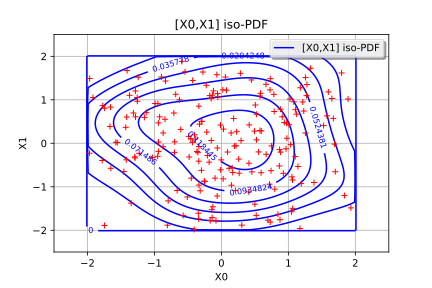

In [36]:
# Draw its PDF
graph = truncatedKS.drawPDF([-2.5] * dimension, [2.5] * dimension, [256] * dimension)
graph.add(ot.Cloud(truncatedKS.getSample(200)))
graph.setColors(["blue", "red"])
graph